In [1]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
%matplotlib inline

# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc

from sklearn.decomposition import PCA


In [2]:
site_groups = ['1000-sites','5000-sites','10000-sites','20000-sites','30000-sites','50000-sites']


In [3]:
import os
os.getcwd()

'/fh/fast/ha_g/user/adoebley/projects/griffin_revisions_1/lung_validation_downsample_cancer_detection/validation_analysis'

1000-sites
Features 1698
Total samples: 287
test samples 431
I         28
II        12
III-IV     6
Name: Stage, dtype: int64


Healthy      385
0-0.03TFx     40
>0.03TFx       6
Name: tfx_group, dtype: int64
number of components: 179
best_c 0.01
training accuracy 0.9651567944250871
test_samples 431
test accuracy 0.62877030162413
iterating


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


roc figure 385 40
roc figure 385 6


5000-sites
Features 1338
Total samples: 287
test samples 431
I         28
II        12
III-IV     6
Name: Stage, dtype: int64


Healthy      385
0-0.03TFx     40
>0.03TFx       6
Name: tfx_group, dtype: int64
number of components: 160
best_c 0.01
training accuracy 0.9372822299651568
test_samples 431
test accuracy 0.7146171693735499
iterating


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


roc figure 385 40
roc figure 385 6


10000-sites
Features 1131
Total samples: 287
test samples 431
I         28
II        12
III-IV     6
Name: Stage, dtype: int64


Healthy      385
0-0.03TFx     40
>0.03TFx       6
Name: tfx_group, dtype: int64
number of components: 148
best_c 0.01
training accuracy 0.926829268292683
test_samples 431
test accuracy 0.7215777262180975
iterating


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


roc figure 385 40
roc figure 385 6


20000-sites
Features 948
Total samples: 287
test samples 431
I         28
II        12
III-IV     6
Name: Stage, dtype: int64


Healthy      385
0-0.03TFx     40
>0.03TFx       6
Name: tfx_group, dtype: int64
number of components: 131
best_c 1.0
training accuracy 1.0
test_samples 431
test accuracy 0.7587006960556845
iterating


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


roc figure 385 40
roc figure 385 6


30000-sites
Features 810
Total samples: 287
test samples 431
I         28
II        12
III-IV     6
Name: Stage, dtype: int64


Healthy      385
0-0.03TFx     40
>0.03TFx       6
Name: tfx_group, dtype: int64
number of components: 119
best_c 10.0
training accuracy 0.9059233449477352
test_samples 431
test accuracy 0.7006960556844548
iterating


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


roc figure 385 40
roc figure 385 6


50000-sites
Features 606
Total samples: 287
test samples 431
I         28
II        12
III-IV     6
Name: Stage, dtype: int64


Healthy      385
0-0.03TFx     40
>0.03TFx       6
Name: tfx_group, dtype: int64
number of components: 100
best_c 10.0
training accuracy 0.8850174216027874
test_samples 431
test accuracy 0.6844547563805105
iterating


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


roc figure 385 40
roc figure 385 6




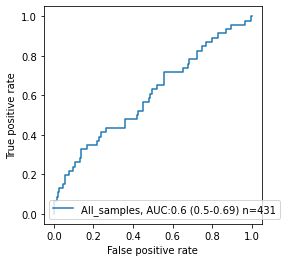

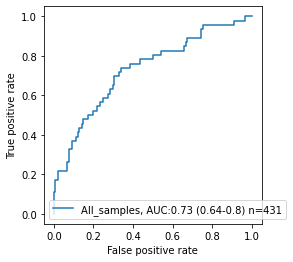

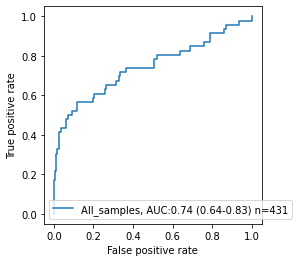

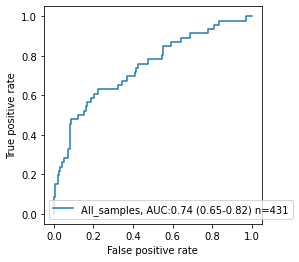

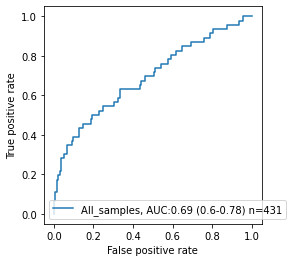

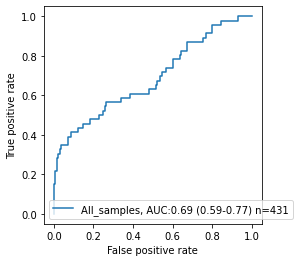

In [4]:
for site_group in site_groups:
    print(site_group)
   #parameters
    in_file = '../number_of_sites_analysis/merged_data/'+site_group+'_LUCAS_reformatted.txt'
    cval_file = '../number_of_sites_analysis/logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.c_values.txt'

    test_data_file = '../number_of_sites_analysis/merged_data/'+site_group+'_validation_reformatted.txt'

    #import training data
    data = pd.read_csv(in_file, sep='\t')
    data = data.set_index('sample')

    #get features and exclude all other columns
    features = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('amplitude'))]

    print('Features',len(features))

    data = data.sort_index()

    print('Total samples:',len(data))

    #scale data
    scaler = StandardScaler()
    scaler.fit(data[features])
    data[features] = scaler.transform(data[features])
    data[features].mean()

    #import test data
    test_data = pd.read_csv(test_data_file, sep='\t')
    test_data = test_data.set_index('sample')

    #test data
    print('test samples',len(test_data))
    test_data['Stage'] = test_data['Stage'].replace('III','III-IV').replace('IV','III-IV') #merge stage III and IV because there are only 6 samples
    print(test_data['Stage'].value_counts())
    print('\n')
    test_data = test_data.sort_index()
    
    
    tfx_limits = [0.03]

    #add tumor fraction groups
    test_data['tfx_group'] = 'none'
    a = 0
    for b in tfx_limits:
        tfx_group_name = str(a)+'-'+str(b)+'TFx'
        test_data['tfx_group'] = np.where((test_data['status']==1) & (test_data['tumor_fraction']>=a) & (test_data['tumor_fraction']<b),tfx_group_name, test_data['tfx_group'])
        a=b
    #if group maxes don't go all the way to 1, add a group > max val
    if b<1:
        tfx_group_name = '>'+str(b)+'TFx'
        test_data['tfx_group'] = np.where((test_data['status']==1) & (test_data['status']==1) & (test_data['tumor_fraction']>=b),tfx_group_name, test_data['tfx_group'])
    #specify tfx group for healthy donors
    test_data['tfx_group'] = np.where((test_data['status']==0),'Healthy',test_data['tfx_group'])

    print(test_data['tfx_group'].value_counts())

    tfx_groups = list(test_data[test_data['status']==1]['tfx_group'].unique())
    
    #scale data
    test_data[features] = scaler.transform(test_data[features])
    test_data[features].mean()

    #perform PCA on the training set
    n_components = min(len(features), len(data))
    pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
    PCs = pca.fit_transform(data[features])
    principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = data.index)

    #find the principle components that make up 80% of the varience
    for j in range(len(pca.explained_variance_ratio_)):
        current_sum = pca.explained_variance_ratio_[:j].sum()
        if current_sum>=0.8:
            break
            
    print('number of components:',j)
    pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

    #apply to the test data
    test_PCs = pca.transform(test_data[features])
    test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = test_data.index)

    data = data[['status','Stage','tumor_fraction']].merge(principal_components, left_index = True, right_index = True)
    test_data = test_data[['status','Stage','tumor_fraction','tfx_group']].merge(test_principal_components, left_index = True, right_index = True)
    features = pca_features
    
    cvals = pd.read_csv(cval_file,sep='\t', header = None)
    best_c = cvals.mode().values[0][0]
    print('best_c',best_c)
    
    #train a  model on the full training dataset 
    model = LogisticRegression(class_weight='balanced', max_iter=500, C=best_c)
    model.fit(data[features], data['status'])

    #predict the test data
    pred = model.predict(data[features])
    prob = model.predict_proba(data[features])

    data['pred']= pred
    data['prob'] = prob[:,1]

    print('training accuracy',sum(data['status'] == data['pred'])/len(data))
    
    #predict the test data
    pred = model.predict(test_data[features])
    prob = model.predict_proba(test_data[features])

    test_data['prediction']= pred
    test_data['probability'] = prob[:,1]

    test_data['accuracy'] = np.where(test_data['prediction']==test_data['status'],1,0)

    
    print('test_samples',len(test_data))
    print('test accuracy',test_data['accuracy'].mean())
    test_data[['status','probability']].to_csv('logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.probabilities.txt', sep='\t', float_format='%.5f')
    
    #get CI
    iterations = 1000
    AUCs = pd.DataFrame()
    print('iterating')
    for i in range(iterations):
        current_results = pd.DataFrame()
        #bootstrap a training set with replacement
        current_sample = test_data.sample(len(test_data), replace = True, random_state = i+100)[['probability','status','tumor_fraction','Stage','tfx_group']]
        current_hd = current_sample[(current_sample['status']==0)]
        fpr, tpr, _ = roc_curve(current_sample['status'].values,current_sample['probability'])
        AUC = auc(fpr,tpr)
        current_results = current_results.append({'group':'overall','AUC':AUC}, ignore_index=True)
        
        for tfx_group in tfx_groups:
            current_ca = current_sample[(current_sample['status']==1) & (current_sample['tfx_group']==tfx_group)]
            current = current_ca.append(current_hd)

            fpr, tpr, _ = roc_curve(current['status'].values,current['probability'])
            AUC = auc(fpr,tpr)
            current_results = current_results.append({'group':tfx_group,'AUC':AUC}, ignore_index=True)

            del(current,AUC,fpr,tpr,current_ca,tfx_group)

        for stage in ['I','II','III-IV']:
            current_ca = current_sample[(current_sample['status']==1) & (current_sample['Stage']==stage)]
            current = current_ca.append(current_hd)

            fpr, tpr, _ = roc_curve(current['status'].values,current['probability'])
            AUC = auc(fpr,tpr)
            current_results = current_results.append({'group':stage,'AUC':AUC}, ignore_index=True)

            del(current,AUC,fpr,tpr,current_ca)

        del(current_sample)
        AUCs = AUCs.append(current_results.set_index('group').T)

    AUCs.reset_index(drop = True).to_csv('logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.AUC.txt', sep='\t', index = False,  float_format='%.5f')
    
    CIs = pd.DataFrame([AUCs.median(), AUCs.quantile(.025), AUCs.quantile(.975)]).T
    CIs = CIs.rename(columns = {'Unnamed 0':'median'}) 
    CIs.to_csv('logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.CI.txt', sep='\t', float_format = '%.5f')
    
    fig,ax = plt.subplots(1)

    fpr, tpr, _ = roc_curve(test_data['status'].values,test_data['probability'])
    med_AUC = CIs.loc['overall']['median']
    lower_AUC = CIs.loc['overall'][0.025]
    upper_AUC = CIs.loc['overall'][0.975]

    ax.plot(fpr,tpr, label = 'All_samples, AUC:'+str(np.round(med_AUC,2))+' ('+str(np.round(lower_AUC,2))+'-'+str(np.round(upper_AUC,2))+') n='+str(len(test_data)))


    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend()
    
    fig,ax = plt.subplots(figsize = (9,6))
    for name,current_ca in test_data[test_data['status']==1].groupby('tfx_group'):
        current_hd = test_data[(test_data['status']==0)]
        print('roc figure',len(current_hd),len(current_ca))
        current = current_ca.append(current_hd)

        fpr, tpr, _ = roc_curve(current['status'].values,current['probability'])
        med_AUC = CIs.loc[name]['median']
        lower_AUC = CIs.loc[name][0.025]
        upper_AUC = CIs.loc[name][0.975]

        ax.plot(fpr,tpr, label = name+' AUC: '+str(np.round(med_AUC,2))+' ('+str(np.round(lower_AUC,2))+'-'+str(np.round(upper_AUC,2))+') n='+str(len(current_ca)))

    ax.set_title(site_group)
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('validation')
    ax.legend(bbox_to_anchor = [1,1], loc = 'upper left')
    ax.set_aspect('equal')

    fig.subplots_adjust(right=.55)

    fig.savefig('logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.AUC.pdf')
    plt.close()
    print('\n')